In [17]:
from get_era5_data_for_station import CreateMatchingEra5FileForStationData
from time_and_date_context import TimeAndDateContext
from create_training_sets import TrainingsFilePair


Process .dat files to create .nc files for the station

In [18]:
station_name = "Barbados"
test_year = 2020

import os
# if in station_data_as_nc folder there is no file with the name of the station, create one
station_as_nc_path = f"{os.getcwd()}/station_data_as_nc/{station_name.lower()}.nc"
needs_to_convert_to_netcdf = not os.path.isfile(station_as_nc_path)
print(f"needs_to_convert_to_netcdf: {needs_to_convert_to_netcdf}")

needs_to_convert_to_netcdf: False


In [19]:
if needs_to_convert_to_netcdf:
    
    from dat_to_nc import DatToNcConverter
    converter = DatToNcConverter(station_name.lower())
    converter.execute()
    import xarray as xr
    ds = xr.open_dataset(converter.target_directory + "/" + converter.name.lower() + ".nc")


  0%|          | 0/1263 [00:00<?, ?it/s]

100%|██████████| 1263/1263 [02:04<00:00, 10.13it/s]

Saving to /home/k/k203179/reconstructing-ai-for-weather-station-data/station_reconstruct/station_data_as_nc/barbados.nc


/home/k/k203179/reconstructing-ai-for-weather-station-data/station_reconstruct/station_data_as_nc/barbados.nc has  30293  values


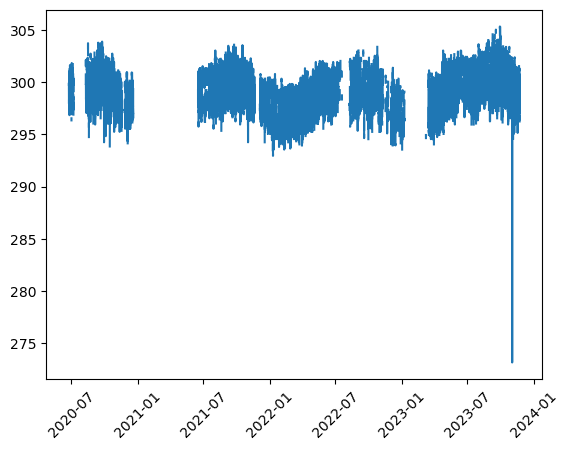

In [20]:
# plot temperature of the station with gaps where no data is available over the years

import matplotlib.pyplot as plt
import xarray as xr

ds = xr.open_dataset(station_as_nc_path)

time_axis = ds.time.values
print(station_as_nc_path, "has ", len(time_axis), " values")
temperature_axis = list(ds.tas.values.flatten())

import pandas as pd
df = pd.DataFrame(temperature_axis, index=time_axis, columns=['tas'])


start_date = None
end_date = None

# plot
if start_date is None or end_date is None:
    plt.plot(df.index, df.tas)
else:
    plt.plot(df[start_date:end_date].index, df[start_date:end_date].tas)

# rotate ticks
plt.xticks(rotation=45)

plt.show()

In [21]:
era5_getter = CreateMatchingEra5FileForStationData(station_name)
station_path = era5_getter.target_station_path
era5_path = era5_getter.target_era5_path
print(f"{station_name} coordinates: {era5_getter.station.get_lon_lat()}")
print(f"The data at {station_name} is inbetween {era5_getter.station.dataset.start_date} and {era5_getter.station.dataset.time_at_index(len(era5_getter.station.dataset.time)-1)}")
print("station cleared & processed file will be saved at: " + station_path)
print("era5 cleared & processed file will be saved at: " + era5_path)

Barbados coordinates: (-59.54316, 13.16443)
The data at Barbados is inbetween 2020-06-08 15:00:00 and 2023-11-22 19:00:00
station cleared & processed file will be saved at: /work/bm1159/XCES/xces-work/k203179/data_sets/barbados.nc
era5 cleared & processed file will be saved at: /work/bm1159/XCES/xces-work/k203179/data_sets/era5_for_barbados.nc


In [22]:
problemantic_files = era5_getter.extract_areas_from_era5_datasets()

choosing example era5 file from /work/bm1159/XCES/data4xces/reanalysis/reanalysis/ECMWF/IFS/ERA5/1hr/atmos/tas/r1i1p1
example_era5_file tas_1hr_reanalysis_era5_r1i1p1_20240101-20240131.nc
getting slices around: (-59.54316, 13.16443)
era5 min / max lin: 1065 1073
era5 min / max lat: 363 371


Processing Files: 100%|██████████| 42/42 [00:24<00:00,  1.71file/s]


Test lon / lat value differences

In [23]:
import netCDF4 as nc
import numpy as np
cropped_folder = era5_getter.target_temp_era5_folder
print(f"cropped_folder: {cropped_folder}")
last_lon = []
last_lat = []
for file in os.listdir(cropped_folder):
    ds = nc.Dataset(f"{cropped_folder}/{file.split('/')[-1]}")
    if len(last_lon):
        assert np.array_equal(last_lon, ds.variables['lon'][:]), f"{last_lon} != {ds.variables['lon'][:]} at {file}"
        assert np.array_equal(last_lat, ds.variables['lat'][:]), f"{last_lat} != {ds.variables['lat'][:]} at {file}"
    last_lon = ds.variables['lon'][:]
    last_lat = ds.variables['lat'][:]


cropped_folder: /work/bm1159/XCES/xces-work/k203179/data_sets_era5-crop_barbados


In [24]:
era5_getter.merge_era5_files()

'/work/bm1159/XCES/xces-work/k203179/data_sets/era5_for_barbados.nc'

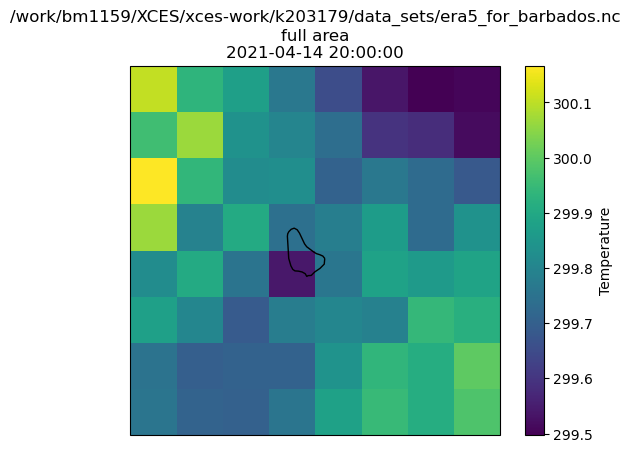

In [25]:
from utils import DataSet, DatasetPlotter
era5_with_time_context = DataSet(era5_getter.target_temp_era5_path)

plotter = DatasetPlotter(era5_with_time_context)
plotter.generate_time_index_list(1)
plotter.plot()

In [26]:
era5_getter.transform_era5_to_match_station_time_dimension()

station data goes from 2020-06-08 15:00:00 to 2023-11-22 19:00:00
era5 data goes from 2020-06-01 00:00:00 to 2023-11-30 23:00:00
cropping time axis to intersection of station and era5 dataset
start/enddate (utc): 2020-06-08 15:00:00 / 2023-11-22 19:00:00


Checking tas: 100%|██████████| 30292/30292 [00:11<00:00, 2585.16it/s]


Found 14432 invalid values in station dataset
Found 0 invalid values in era5 dataset


100%|██████████| 14432/14432 [00:22<00:00, 650.81it/s]


Deleted 14432 timesteps from /home/k/k203179/reconstructing-ai-for-weather-station-data/station_reconstruct/station_data_as_nc/barbados.nc_temp dataset because of invalid values


100%|██████████| 14432/14432 [00:28<00:00, 501.40it/s]

Deleted 14432 timesteps from /work/bm1159/XCES/xces-work/k203179/data_sets/era5_for_barbados.nc_temp dataset because of invalid values


('/work/bm1159/XCES/xces-work/k203179/data_sets/barbados.nc',
 '/work/bm1159/XCES/xces-work/k203179/data_sets/era5_for_barbados.nc')

/work/bm1159/XCES/xces-work/k203179/data_sets/era5_for_barbados.nc has  15861  values


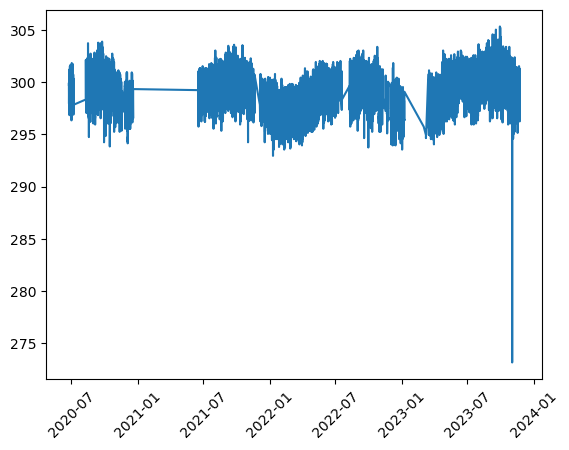

In [27]:
# plot temperature of the station with gaps where no data is available over the years

import matplotlib.pyplot as plt
import xarray as xr

ds = xr.open_dataset(station_path)
time_axis = ds.time.values
print(era5_path, "has ", len(time_axis), " values")
temperature_axis = list(ds.tas.values.flatten())

# plot
plt.plot(time_axis, temperature_axis)

# rotate x axis labels
plt.xticks(rotation=45)

plt.show()

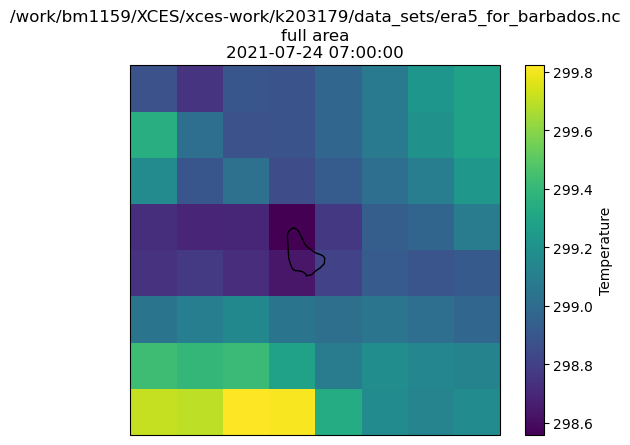

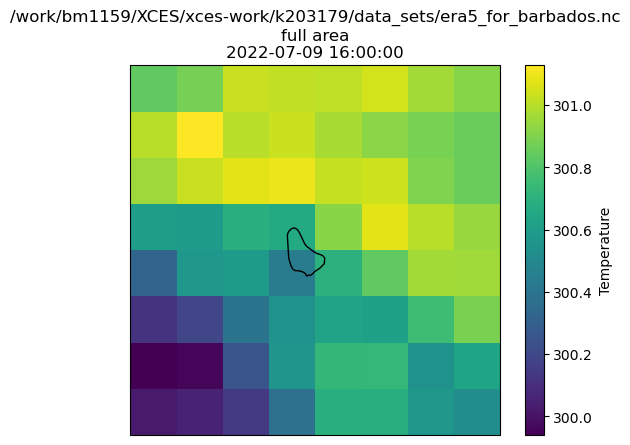

In [28]:
from utils import DataSet, DatasetPlotter
era5_with_time_context = DataSet(era5_path)
plotter = DatasetPlotter(era5_with_time_context)
plotter.generate_time_index_list(2)
plotter.plot()

In [29]:
time_context_adder = TimeAndDateContext()
time_context_adder.generate_time_context_variables_in_dataset(era5_path)


100%|██████████| 15861/15861 [01:25<00:00, 185.92it/s]


                     year  intra_year_1  intra_year_2  intra_day_1  \
2020-06-23 19:00:00  20.0      0.128748     -0.991677    -0.965926   
2020-06-23 20:00:00  20.0      0.128748     -0.991677    -0.866025   
2020-06-23 21:00:00  20.0      0.128748     -0.991677    -0.707107   
2020-06-23 22:00:00  20.0      0.128748     -0.991677    -0.500000   
2020-06-23 23:00:00  20.0      0.128748     -0.991677    -0.258819   
...                   ...           ...           ...          ...   
2023-11-22 15:00:00  23.0     -0.622047      0.782980    -0.707107   
2023-11-22 16:00:00  23.0     -0.622047      0.782980    -0.866025   
2023-11-22 17:00:00  23.0     -0.622047      0.782980    -0.965926   
2023-11-22 18:00:00  23.0     -0.622047      0.782980    -1.000000   
2023-11-22 19:00:00  23.0     -0.622047      0.782980    -0.965926   

                      intra_day_2  
2020-06-23 19:00:00  2.588190e-01  
2020-06-23 20:00:00  5.000000e-01  
2020-06-23 21:00:00  7.071068e-01  
2020-06-23 22:0

In [30]:
# convert F64 to F32 using cdo -b F32 copy input.nc output.nc
import subprocess
subprocess.run(["cdo", "-b", "F32", "copy", era5_path, era5_path + "_f32"])

os.system(f"mv {era5_path + '_f32'} {era5_path}")

0

In [31]:
trainings_file_pair_creator = TrainingsFilePair(station_path, era5_path, test_year=test_year)
trainings_file_pair_creator.prepare_trainings_files()

preparing /work/bm1159/XCES/xces-work/k203179/data/val/barbados.nc: 100%|██████████| 16/16 [00:00<00:00, 1645.91it/s]
preparing /work/bm1159/XCES/xces-work/k203179/data/train/barbados.nc: 100%|██████████| 15845/15845 [00:09<00:00, 1717.56it/s]


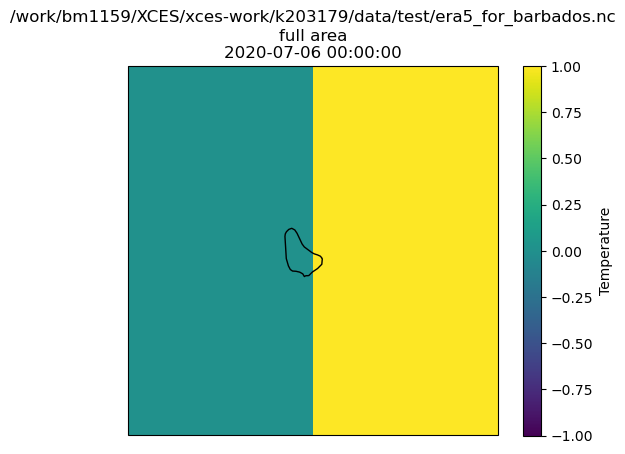

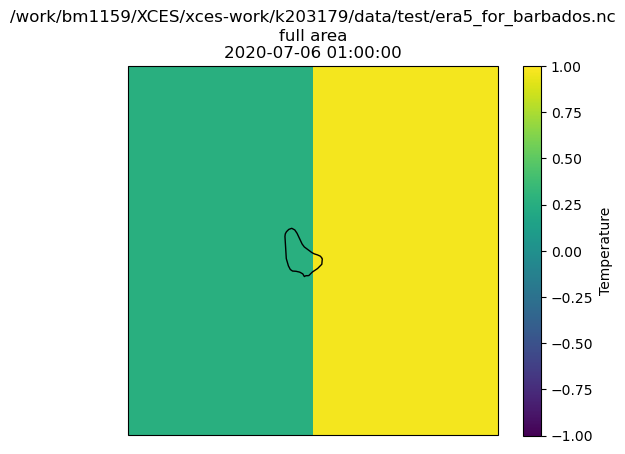

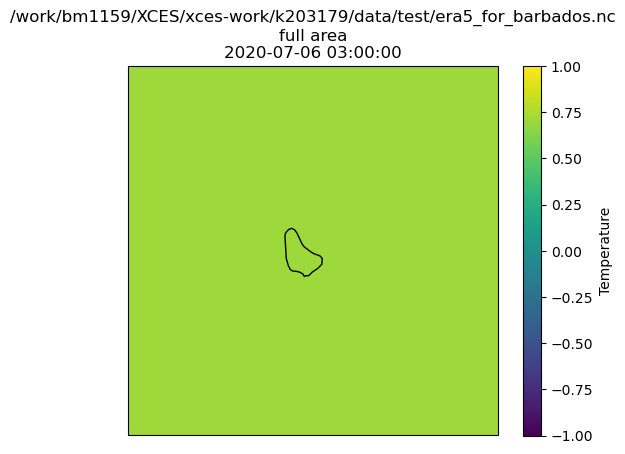

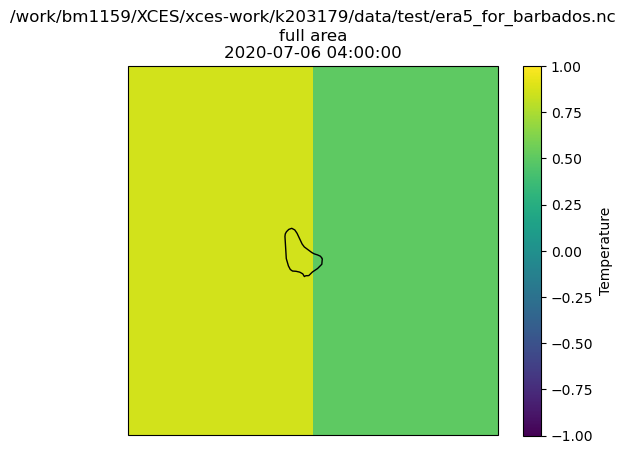

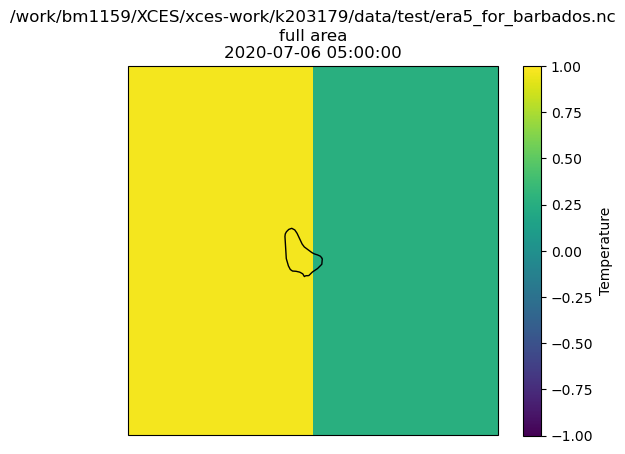

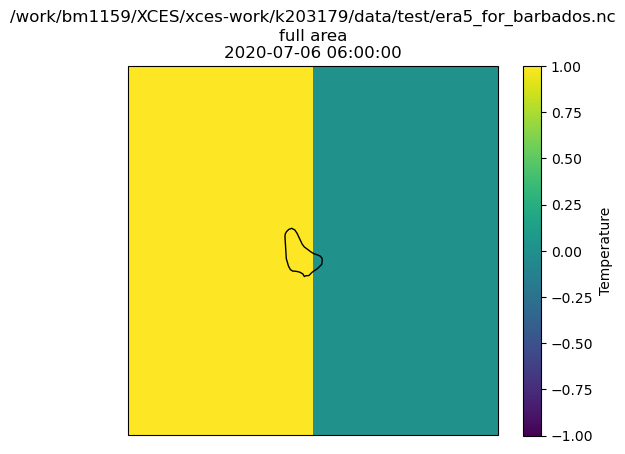

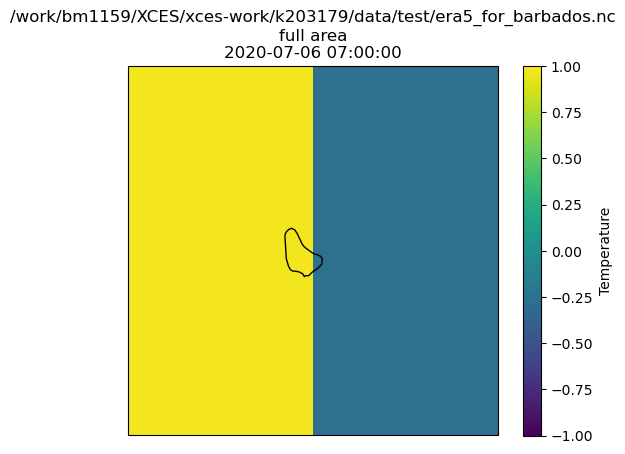

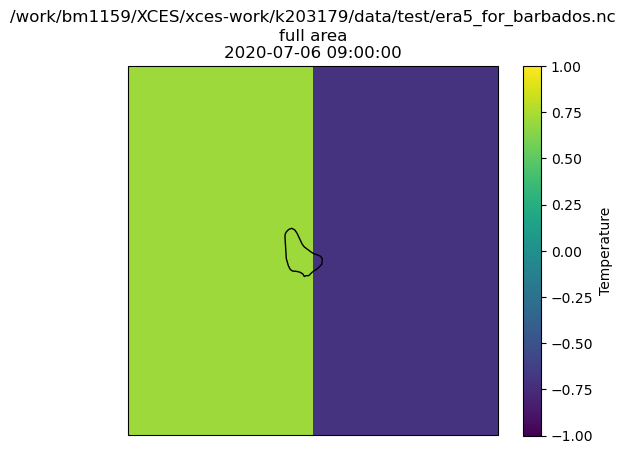

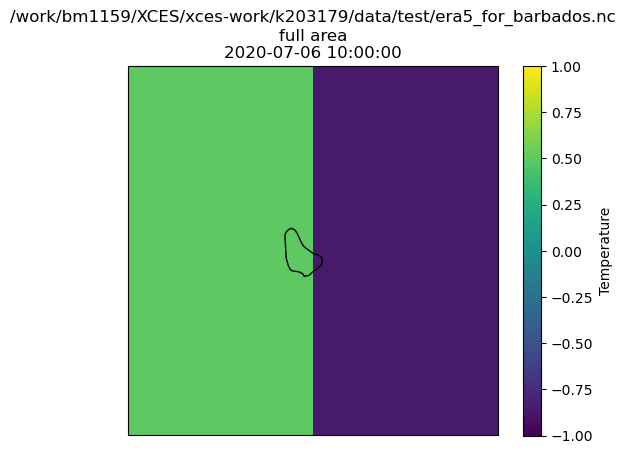

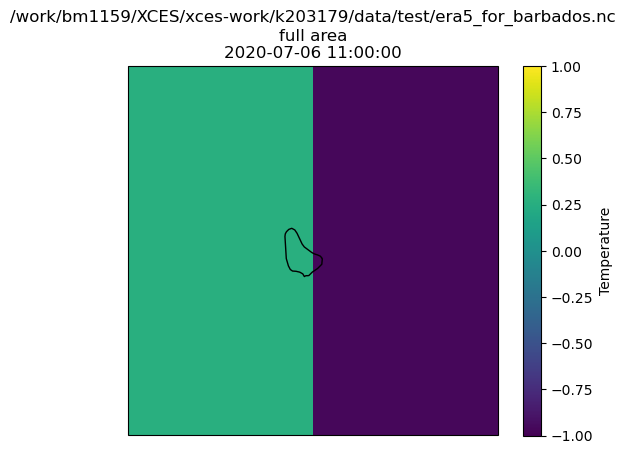

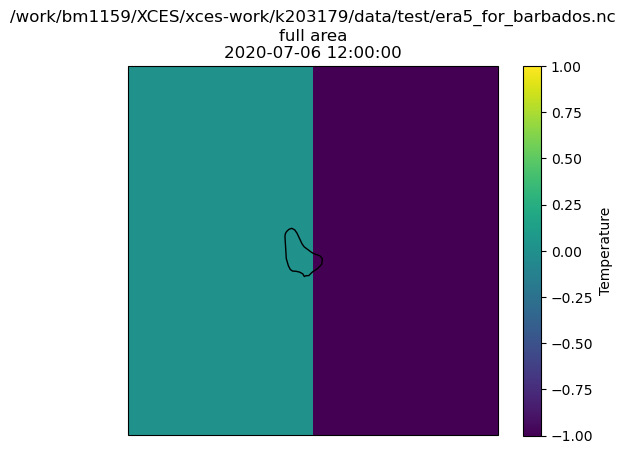

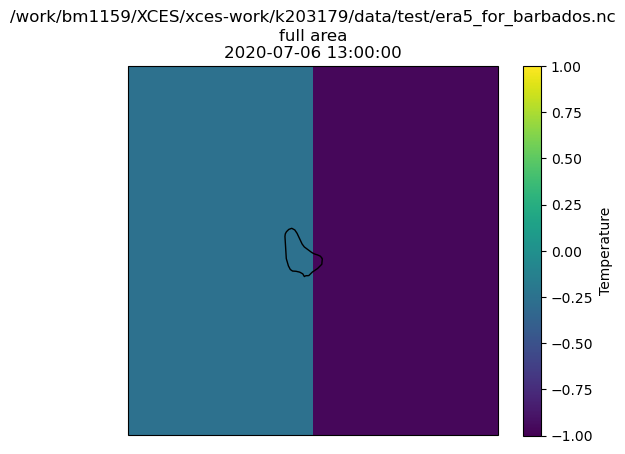

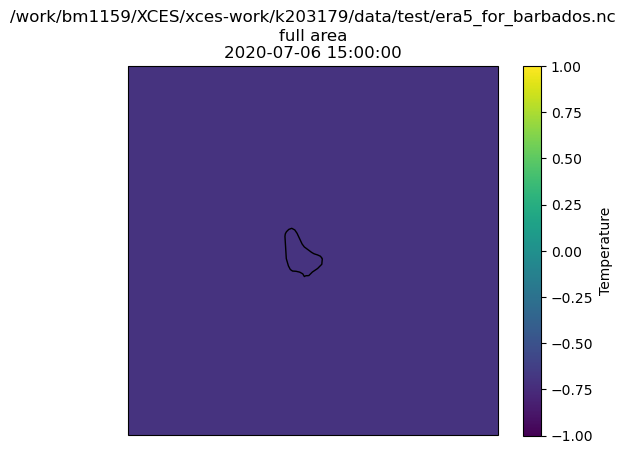

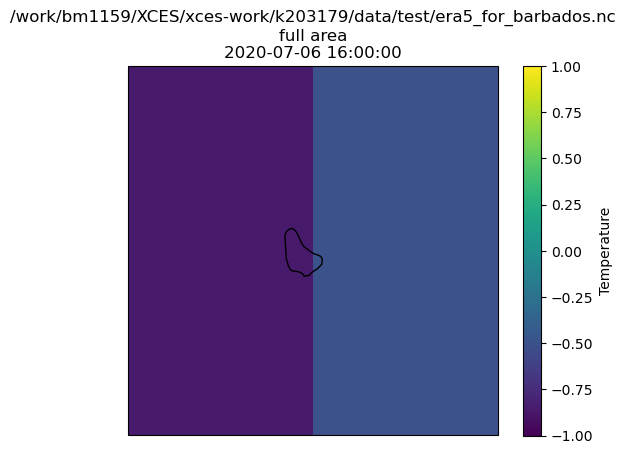

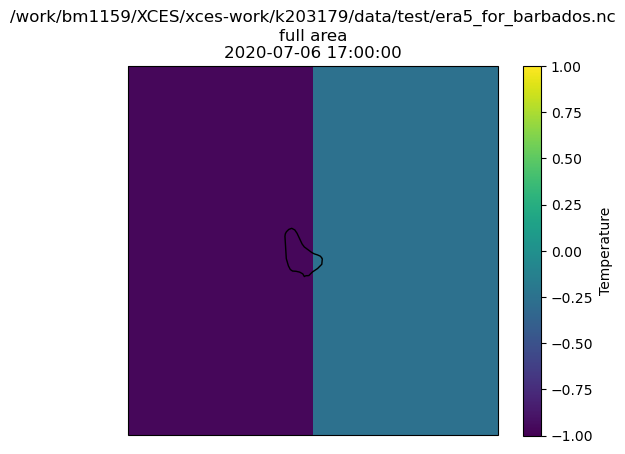

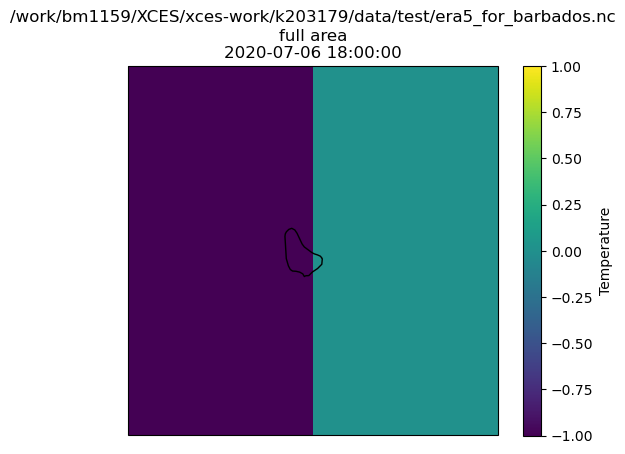

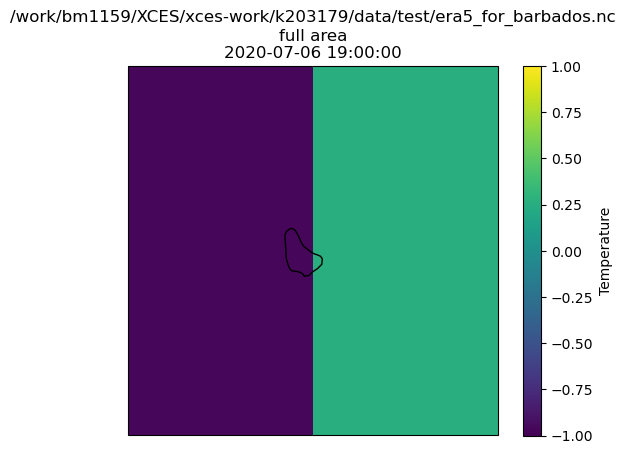

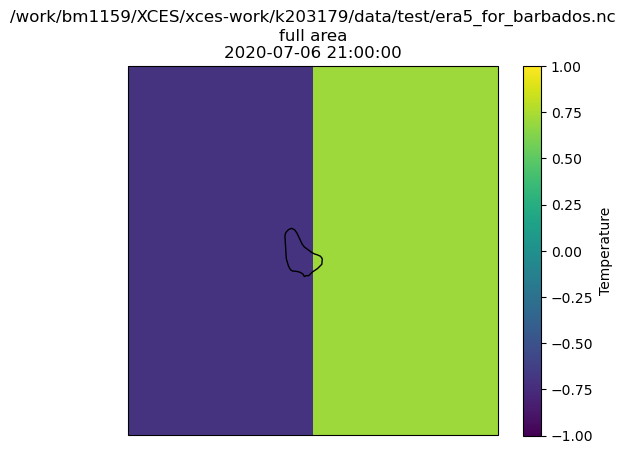

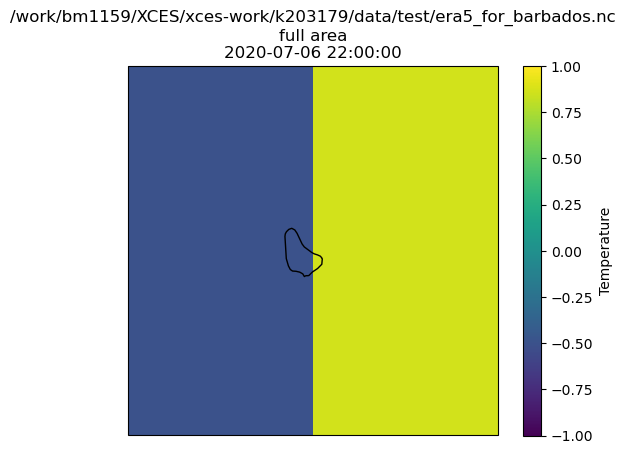

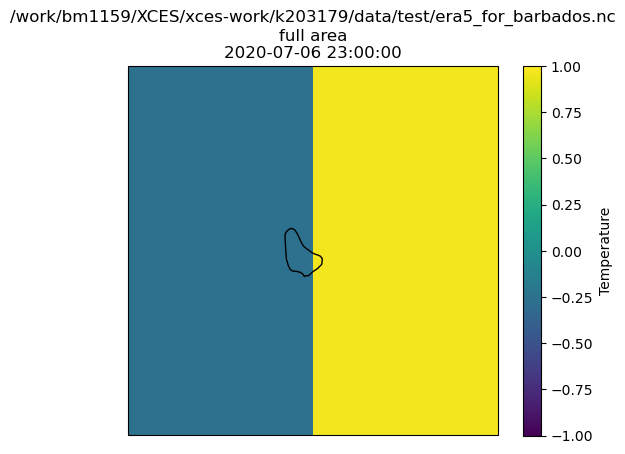

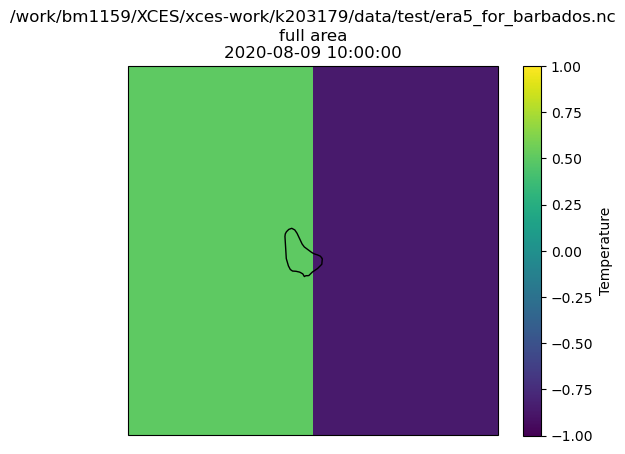

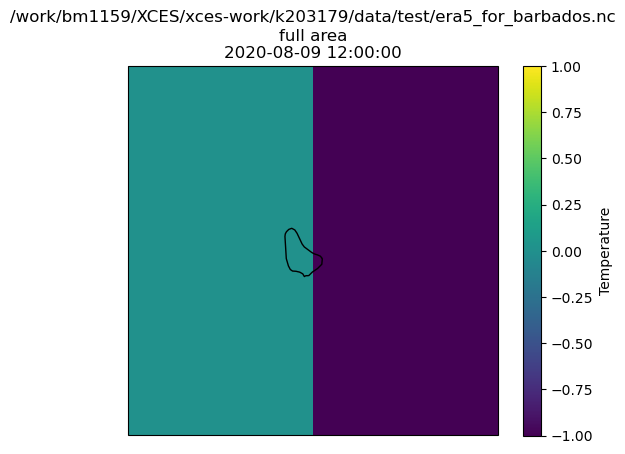

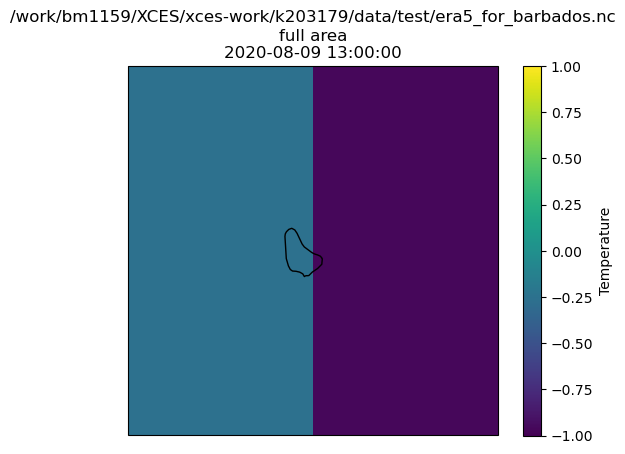

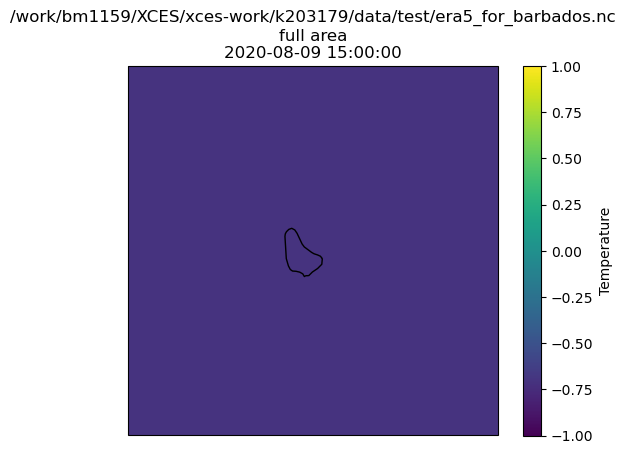

In [32]:
from utils import DataSet, DatasetPlotter
test_expected_set = DataSet(f"/work/bm1159/XCES/xces-work/k203179/data/test/era5_for_{station_name.lower()}.nc")
plotter = DatasetPlotter(test_expected_set)
plotter.time_index_list = [x + 222 for x in range(0, 24)]
plotter.vmin = -1
plotter.vmax = 1
plotter.plot(var="intra_day")